In [1]:
import numpy as np
import pandas as pd 
import pickle as pk
import matplotlib as plt
%matplotlib inline
from IPython.display import display, HTML

datapath = 'data/tcd ml 2019-20 income prediction training (with labels).csv'

## Replace country's name with its GDP, see cell below:
# source: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD
# The top rows were removed to aid in parsing
# gdp = pd.read_csv('data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_180634.csv', skiprows=[0, 1, 2, 3])

# Prepare data for ml algorithm

In [2]:
# These were used to relate a country's name with its GDP according 
# to the world bank, turned out to be more useful to calculate average
# income from the data itself

# def clean_country(country):
#     try:
#         return {
#             'Laos': 'Lao PDR',
#             'Kyrgyzstan': 'Kyrgyz Republic',
#             'Slovakia': 'Slovak Republic',
#             'Congo': 'Congo, Rep.',
#             'DR Congo': 'Congo, Dem. Rep.',
#             # Nothing political intended here, trying to be realistic about income
#             'State of Palestine': 'Jordan',
#             'Syria': 'Syrian Arab Republic',
#             'Gambia': 'Gambia, The',
#             'North Korea': 'Korea, Dem. People’s Rep.',
#             'South Korea': 'Korea, Rep.',
#             'Côte d\'Ivoire': 'Cote d\'Ivoire',
#             'Venezuela': 'Venezuela, RB',
#             'Yemen': 'Yemen, Rep.',
#             'Brunei': 'Brunei Darussalam',
#             'Micronesia': 'Micronesia, Fed. Sts.',
#             'Bahamas': 'Bahamas, The',
#             'Saint Lucia': 'St. Lucia',
#             'Czechia': 'Czech Republic',
#             'Sao Tome & Principe': 'Sao Tome and Principe',
#         }[country]
#     except KeyError:
#         return country

# def get_index_equiv(year):
#     return year - 1956

# def country_to_gdp(countries):
#     return_val = {}
#     for country in countries:
#         try:
#             gdpval = np.nan
#             year = 2018
#             while np.isnan(gdpval):
#                 gdpval = gdp.loc[gdp['Country Name'] == clean_country(country)].iloc[:, get_index_equiv(year)].item()
#                 year -= 1
#                 if year < 1960:
#                     if country == 'North Korea':
#                         # There isn't World Bank data for NK, let's assume it's USD32 Billion
#                         gdpval = float(32000000000)
#                     else:
#                         raise IndexError('Could not find GDP')
#             return_val[country] = gdpval
#         except ValueError:
#             print('Country Error, check : clean_country() -> ', country)
#     return return_val

In [3]:
from sklearn.preprocessing import LabelBinarizer

# This whittles the list of jobs by reducing it to a fixed
# length and where jobs of a particular category are less
# than some threshold, add them to an unknown category
def shorten_jobs(jobs, length=8, thresh=80):
    return_val = {}
    for key in jobs:
        if jobs[key] > thresh:
            try:
                new_key = key[:length]
            except TypeError:
                new_key = 'unkn'
        else:
            new_key = 'unkn'
        return_val[key] = new_key
    
    # Make sure that there aren't any duplicates
    for key in return_val:
        try:
            return_val[return_val[key]]
            return_val[key] = 'unkn'
        except KeyError:
            continue
    
    return return_val

# I wrote this so that the one htoe encoding strategy can be
# pickled
def one_hot_encode(data, column):
    degree_encoder = LabelBinarizer()
    degree_encoder.fit(data[column])
    pk.dump(degree_encoder, open(column.replace(' ', '_') + '.pkl', mode='wb'))
    transformed = degree_encoder.transform(data[column])
    ohe_df = pd.DataFrame(transformed)
    return pd.concat([data, ohe_df], axis=1).drop([column], axis=1)

# Used for calculating the average income for each category within a
# column, eg, the average income for a country or profession
def fit_to_value(data, column):
    values = pd.Series.to_dict(data[column])
    incomes = pd.Series.to_dict(data['Income in EUR'])
    assert(len(values) == len(incomes))
    
    fitted = {}
    for i in range(len(values)):
        try:
            fitted[values[i]].append(incomes[i])
        except KeyError:
            fitted[values[i]] = []
            fitted[values[i]].append(incomes[i])
    
    for country in fitted:
        fitted[country] = sum(fitted[country]) / len(fitted[country])
    pk.dump(fitted, open(column + '.pkl', mode='wb'))
    return fitted

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [4]:
# This is the entry point through which the data is cleaned,
# going through one column at a time, it takes a number of 
# parameters to change its behavior easily
def process_data(path, 
                 Instance_drop, 
                 Year_of_Record_drop, 
                 Gender_drop, 
                 Age_drop, 
                 Country_drop, 
                 Size_of_City_drop, 
                 Profession_drop, 
                 University_Degree_drop, 
                 Wears_Glasses_drop, 
                 Hair_Color_drop, 
                 Body_Height_cm_drop,
                 prof_len=4,
                 prof_cutoff=80,
                 replace_gdp = True,
                 replace_est_gdp = False,
                 scale_uni = True,
                 drop_income_outlier = True,
                 income_cutoff = 1000000,
                 income_lower=0,
                 gdp_cutoff = 1.5*pow(10,12),
):

    data = pd.read_csv(path)
    data = data.fillna(value=0)

    ## 'Instance'
    print(' * INFO: Processing \'Instance\'')
    if Instance_drop == True:
        data = data.drop(labels='Instance', axis=1)
    else:
        pass

    ## 'Year of Record'
    print(' * INFO: Processing \'Year of Record\'')
    if Year_of_Record_drop == True:
        data = data.drop(labels='Year of Record', axis=1)
    else:
        data = data.replace(to_replace={'Year of Record': {
                0: 2000,
        }})

    ## 'Gender'
    print(' * INFO: Processing \'Gender\'')
    if Gender_drop == True:
        data = data.drop(labels='Gender', axis=1)
    else:
        data = data.replace(to_replace={'Gender': {
                'male': 1,
                'female': -1,
                'other': 0,
                'unknown': 0,
                '0': 0,
                np.nan: 0,
        }})

    ## 'Age'
    print(' * INFO: Processing \'Age\'')
    if Age_drop == True:
        data = data.drop(labels='Age', axis=1)
    else:
        data = data.replace(to_replace={'Age': {
                0: 40,
        }})

    ## 'Country'
    print(' * INFO: Processing \'Country\'')
    assert((replace_gdp != replace_est_gdp) or ((replace_gdp == False) and (replace_est_gdp == False))
    ),'replace_gdp and replace_est_gdp cannot both be True'
    # Replace country with its GDP
    if Country_drop == True:
        data = data.drop(labels='Country', axis=1)
    else:
        if replace_gdp == True:
            country_gdp = {'Country': country_to_gdp(pd.Series.to_dict(data['Country'].value_counts()))}
            data = data.replace(to_replace=country_gdp)
        elif replace_est_gdp == True:
            country_gdp = {'Country': fit_to_value(data, 'Country')}
            data = data.replace(to_replace=country_gdp)
        else:
            data = one_hot_encode(data, 'Country')

    ## 'Size of City'
    print(' * INFO: Processing \'Size of City\'')
    if Size_of_City_drop == True:
        data = data.drop(labels='Size of City', axis=1)
    else:
        pass

    ## 'Profession'
    print(' * INFO: Processing \'Profession\'')
    if Profession_drop == True:
        data = data.drop(labels='Profession', axis=1)
    else:
        # shorten labels
        new_jobs = {'Profession': 
                    shorten_jobs(
                        pd.Series.to_dict(data['Profession'].value_counts()), 
                        prof_len,
                        prof_cutoff
                    )}
        pk.dump(new_jobs, open('jobs.pkl', mode='wb'))
        data = data.replace(to_replace=new_jobs)
        
        newjobs = {'Profession': fit_to_value(data, 'Profession')}
        data = data.replace(to_replace=newjobs)

#         # one-hot encode 
#         data = one_hot_encode(data, 'Profession')

    ## 'University Degree'
    print(' * INFO: Processing \'University Degree\'')
    if University_Degree_drop == True:
        data = data.drop(labels='University Degree', axis=1)
    else:
        if scale_uni == True:
            data = data.replace(to_replace={'University Degree': {
                    'PhD': 3,
                    'Master': 2,
                    'Bachelor': 1,
                    '0': 0,
                    'No': 0,
                    np.nan: 0,
            }})
            data['University Degree'] = pd.to_numeric(data['University Degree'], downcast='float')
        else:
            data = data.replace(to_replace={'University Degree': {
                    '0': 'No',
                    0: 'No',
                    np.nan: 'No',
            }})

            data = one_hot_encode(data, 'University Degree')

    ## 'Wears Glasses'
    print(' * INFO: Processing \'Wears Glasses\'')
    if Wears_Glasses_drop == True:
        data = data.drop(labels='Wears Glasses', axis=1)
    else:
        pass

    ## 'Hair Color'
    print(' * INFO: Processing \'Hair Color\'')
    if Hair_Color_drop == True:
        data = data.drop(labels='Hair Color', axis=1)
    else:
        data = data.replace(to_replace={'Hair Color': {
                np.nan: 'Unknown',
                '0': 'Unknown',
                0: 'Unknown',
        }})
        data = one_hot_encode(data, 'Hair Color')

    ## 'Body Height [cm]'
    print(' * INFO: Processing \'Body Height [cm]\'')
    if Body_Height_cm_drop == True:
        data = data.drop(labels='Body Height [cm]', axis=1)
    else:
        pass

    ## 'Income in EUR'
    print(' * INFO: Processing \'Income in EUR\'')
    if drop_income_outlier == True:
        data = data[data['Income in EUR'] < income_cutoff] 
        data = data[data['Income in EUR'] > income_lower] 
        
    else:
        pass
    
    return data

def split__scale_data(data):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
    from sklearn.model_selection import train_test_split

    X = data.drop(columns=['Income in EUR'])#.to_numpy()
    y = data['Income in EUR'].to_numpy()

    scaler = StandardScaler()
    scaler.fit(X)
    pk.dump(scaler, open('scaler.pkl', mode='wb'))

    X = scaler.transform(X)
#     Uncomment this when exporting
#     return X, y
    return train_test_split(X, y, test_size=0.2, random_state=12120)

# Process and train

In [5]:
##### print(' * INFO: Processing data')
data = process_data(
    datapath, 
    
    Instance_drop           = True,
    Year_of_Record_drop     = False,
    Gender_drop             = True,
    Age_drop                = False,
    Country_drop            = False,
    Size_of_City_drop       = True,
    Profession_drop         = False,
    University_Degree_drop  = False, 
    Wears_Glasses_drop      = False, 
    Hair_Color_drop         = True, 
    Body_Height_cm_drop     = False, 
    
    prof_len                = 2,
    prof_cutoff             = 1,
    
    replace_gdp             = False,
    replace_est_gdp         = True,
    scale_uni               = True,
    drop_income_outlier     = True,
    income_cutoff           = 1000000,
    income_lower            = 10,
    gdp_cutoff              = 1.5*pow(10,12),
)
#     Uncomment this when exporting
# X, y = split__scale_data(data)
X_train, X_test, y_train, y_test = split__scale_data(data)

# print(' * INFO: Data processed, training')

 * INFO: Processing 'Instance'
 * INFO: Processing 'Year of Record'
 * INFO: Processing 'Gender'
 * INFO: Processing 'Age'
 * INFO: Processing 'Country'
 * INFO: Processing 'Size of City'
 * INFO: Processing 'Profession'
 * INFO: Processing 'University Degree'
 * INFO: Processing 'Wears Glasses'
 * INFO: Processing 'Hair Color'
 * INFO: Processing 'Body Height [cm]'
 * INFO: Processing 'Income in EUR'


In [6]:
# from sklearn.linear_model import LinearRegression # 0.7329071392165241
# from sklearn.tree import DecisionTreeRegressor # 0.6533532065416456
# from sklearn.neighbors import KNeighborsRegressor # 0.8073718799265437
# from sklearn.neural_network import MLPRegressor # 0.7762418521620275
# from sklearn.gaussian_process import GaussianProcessRegressor # Kernel crashed
# from sklearn.svm import SVR # -0.10307511854272701
# from sklearn.ensemble import AdaBoostRegressor # 0.6699900635517028
# from sklearn.ensemble import RandomForestRegressor # 0.8317639753681769 /w 50 estimators
# from sklearn.ensemble import BaggingRegressor # 0.8415911585657341 n_estimators=100, 
from sklearn.ensemble import GradientBoostingRegressor # 0.8513631606602606 n_estimators=300,
# from sklearn.linear_model import TheilSenRegressor

func = GradientBoostingRegressor(
    n_estimators=500, 
#     n_jobs=-1,
#     estimators=None,
    random_state=2645, # for consistency between runs
    # verbose=0
)
# Change to X, y when exporting
func.fit(X_train, y_train)
print(' * INFO: Score = ', func.score(X_test, y_test))

 * INFO: Score =  0.8539132041077172


In [7]:
pk.dump(func, open('predictor.pkl', mode='wb'))

# Explore processed data

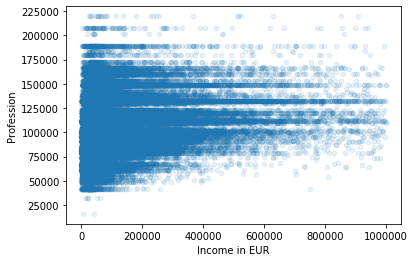

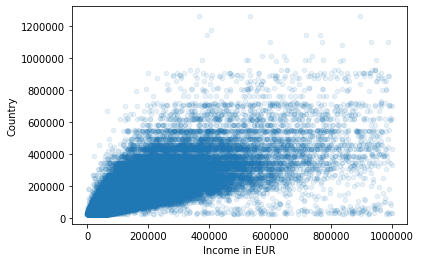

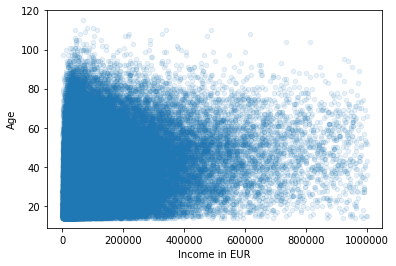

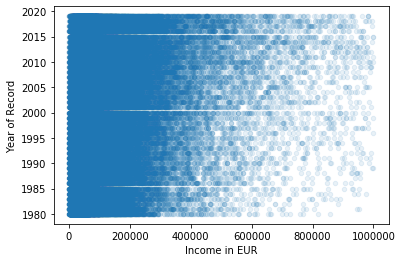

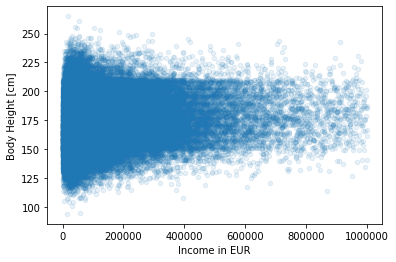

In [8]:
attr = [
    'Profession', 
    'Country', 
    'Age', 
    'Year of Record', 
#     'University Degree', 
    'Body Height [cm]',
#     'Size of City',
#     'Gender',
#     'Wears Glasses',
    'Income in EUR'
]
for i in range(len(attr) - 1):
    data.plot(kind='scatter', x='Income in EUR', y=attr[i], alpha=0.1)

In [9]:
# This removes the scrollbar if it appears in the cell above
display(HTML("<script>$('.output_scroll').removeClass('output_scroll')</script>"))